# __Collaborative Filtering Based Recommender Systems using Low Rank Matrix Factorization(User & Movie Embeddings) & Neural Network in Keras.__

## __CONTENTS__

[ **1 ) Exploratory the Data**](#content1)

[ **2 ) Preparing the Data**](#content2)

[ **3 ) Matrix Factorization**](#content3)

[ **4 ) Evaluating the Model Performance**](#content4)

[ **5 ) Using a Neural Network**](#content5)

<a id="content1"></a>
## __1 ) Exploring the Data__

### 1.1 ) Importing Various Modules

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotilb to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

# model selcetion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# preprocess.
from keras.preprocessing.image import ImageDataGenerator

# d1 libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, merge
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau

from keras.layers.merge import dot
from keras.models import Model

# specifically for deeplearning.
from keras.layers import Dropout, Flatten, Activation, Input, Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

# TL specific modules
from keras.applications.vgg16 import VGG16

### 1.2 ) Reading the CSV file

In [2]:
train = pd.read_csv(r'./input_2/MovieLens-100K/ratings.csv')

여기서는 MovieLens-100K 데이터를 활용하였으며, 약 10만개의 평점 정보를 활용하여 테스트

In [3]:
train

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [4]:
df = train.copy()
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### 1.3 ) Exploring the dataset

In [5]:
print(len(df['userId'].unique()))
df['userId'].unique()

671


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [6]:
print(len(df['movieId'].unique()))
df['movieId'].unique()

9066


array([  31, 1029, 1061, ...,  129, 4736, 6425])

671명의 유저 아이디 존재하며, 9066개의 영화에 대한 평점 데이터이다.

#### Note that for 671 users and 9066 movies we can have a maximum of 671*9066 = 6083286 ratings. But note that we have only 100004 ratings with us. Hence the utility matrix has only about 1.6 % of the total values. Thus it can be concluded that it is quite sparse. This limits the use of some algorithms. Hence we will create embeddings for them later.

In [7]:
df['userId'].isnull().sum()

0

In [8]:
df['rating'].isnull().sum()

0

In [9]:
df['movieId'].isnull().sum()

0

NULL이나 Nan 값이 없는 것 확인

In [10]:
print(df['rating'].min())
print(df['rating'].max())

0.5
5.0


<a id="content2"></a>
## 2 ) Preparing the Data

### 2.1 ) Encoding the columns

In [11]:
df

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [12]:
# 카테고리를 숫자 인덱스로 변환
df.userId = df.userId.astype('category').cat.codes.values
df.movieId = df.movieId.astype('category').cat.codes.values

In [13]:
df

,userId,movieId,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205
...,...,...,...,...
99999,670,4545,2.5,1065579370
100000,670,4546,4.0,1065149201
100001,670,4597,4.0,1070940363
100002,670,4610,2.5,1070979663


In [14]:
df['userId'].value_counts(ascending=True)

0        20
208      20
248      20
324      20
437      20
       ... 
72     1610
14     1700
623    1735
563    1868
546    2391
Name: userId, Length: 671, dtype: int64

In [15]:
print(len(df['movieId'].unique()))
df['movieId'].unique()

9066


array([  30,  833,  859, ...,  115, 3712, 4629], dtype=int16)

### 2.2 ) Creating the Utility Matrix

In [16]:
# creating utility matrix.
index = list(df['userId'].unique())
columns = list(df['movieId'].unique())
index = sorted(index)
columns = sorted(columns)

util_df = pd.pivot_table(data=df, values='rating', index='userId', columns='movieId')
# Nan implies that user has not rated the corressponding movie.

In [17]:
util_df

movieId,0,1,2,3,4,5,6,7,8,9,...,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
userId,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### BREAKING IT DOWN--

1) This is the utility matrix; for each of the 671 users arranged rowwise; each column shows the rating of the movie given by a particular user.

2) Note that majority of the matrix is filled with 'Nan' which shows that majority of the movies are unrated by many users.

3) For each movie-user pair if the entry is NOT 'Nan' the vaue indicates the rating given by user to that corressponding movie. 

4) For now I am gonna fill the 'Nan' value with value '0'. But note that this just is just indicative, a 0 implies NO RATING and doesn't mean that user has rated 0 to that movie. It doesn't at all represent any rating.

In [18]:
util_df = util_df.fillna(0)

In [19]:
util_df

movieId,0,1,2,3,4,5,6,7,8,9,...,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
userId,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.3 ) Creating Training and Validation Sets.

In [20]:
df

,userId,movieId,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205
...,...,...,...,...
99999,670,4545,2.5,1065579370
100000,670,4546,4.0,1065149201
100001,670,4597,4.0,1070940363
100002,670,4610,2.5,1070979663


In [21]:
# x_train,x_test,y_train,y_test=train_test_split(df[['userId','movieId']],df[['rating']],test_size=0.20,random_state=42)
users = df.userId.unique()
movies = df.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

Note.

numpy의 np.random. randint vs rand/randn

- np.random.seed: seed를 통한 난수 생성
- np.random.__randint__: 균일 분포의 정수 난수 1개 생성
- np.random.__rand__: 0부터 1사이의 균일 분포에서 난수 matrix array 생성
- np.random.__randn__: 가우시안 표준 정규 분포에서 난수 matrix array 생성


- np.random.shuffle: 기존의 데이터의 순서 바꾸기
- np.random.choice 기존의 데이터에서 sampling
- np.unique: 데이터에서 중복된 값을 제거하고 중복되지 않는 값의 리스트를 출력
- np.bincount: 발생하지 않은 사건에 대해서 카운터

In [22]:
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(df)) < 0.8
print(split)
train = df[split]
valid = df[~split]
print(train.shape, valid.shape)

[ True  True  True ...  True  True  True]
(80189, 4) (19815, 4)


<a id="content3"></a>
## 3 ) Matrix Factoriztion

#### Here comes the main part!!!      

1) Now we move on to the crux of the notebook ie Matrix Factorization. In matrix facorization, we basically break a matrix into usually 2 smaller matrices each with smaller dimensions. these matrices are oftem called 'Embeddings'.  We can have variants of Matrix Factorizartion-> 'Low Rank MF' , 'Non-Negaive MF' (NMF) and so on..  

2) Here I  have used the so called 'Low Rank Matrix Factorization'.  I have created  embeddings for both user as well as the item; movie in our case. The number of dimensions or the so called 'Latent Factors' in the embeddings is a hyperparameter to deal with in this implementation of Collaborative Filtering.                                                  

### 3.1 ) Creating the Embeddings, Merging and Making the Model from Embeddings

In [23]:
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())
n_latent_factors = 64  # hyperparmeter to deal with.

In [24]:
user_input = Input(shape=(1,), name='user_input', dtype='int64')

In [25]:
user_input

<tf.Tensor 'user_input:0' shape=(None, 1) dtype=int64>

In [26]:
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)

In [27]:
user_embedding

<tf.Tensor 'user_embedding/embedding_lookup/Identity_1:0' shape=(None, 1, 64) dtype=float32>

In [28]:
user_vec = Flatten(name='FalttenUsers')(user_embedding)

In [29]:
user_vec

<tf.Tensor 'FalttenUsers/Reshape:0' shape=(None, 64) dtype=float32>

In [30]:
movie_input = Input(shape=(1,), name='movie_input', dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FalttenMovies')(movie_embedding)

In [31]:
# dot-product를 사용한 유사도 측정.
# mulitply, cosine similarity 등을 활용해도 됨.

sim = dot([user_vec, movie_vec], name='Similarity-Dot-Product', axes=1)
model = keras.models.Model([user_input, movie_input], sim)

In [32]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        42944       user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 64)        580224      movie_input[0][0]                
_______________________________________________________________________________________

#### BREAKING IT DOWN--

1) First we need to create embeddings for both the user as well as the item or movie. For this I have used the Embedding layer from keras.

2) Specify the input expected to be embedded (Both in user and item embedding). The use a Embedding layer which expects the no of latent factors in the resulting embedding and also the no of users or items.

3) Then we take the 'Dot-Product' of both the embeddings using the 'merge' layer. Note that 'dot-product' is just a measure of simalrity and we can use any other mode like 'mulitply' or 'cosine simalarity' or 'concatenate' etc...

4) Lastly we make a Keras model from the specified details.


### 3.2 ) Compiling the Model

In [33]:
model.compile(optimizer=Adam(lr=1e-4), loss='mse')

Note that the metrics used is 'Mean squared Error'. Our aim is to minimize the mse on the training set ie over the values which the user has rated (100004 ratings).

In [34]:
train.shape
batch_size = 128
epochs = 50

### 3.3 ) Fitting on Training set & Validating on Validation Set.

In [35]:
History = model.fit([train.userId, train.movieId],
                    train.rating,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=([valid.userId, valid.movieId], valid.rating),
                   verbose=1)

Epoch 1/50
627/627 [==============================] - 2s 4ms/step - loss: 13.6833 - val_loss: 13.6484
Epoch 2/50
627/627 [==============================] - 2s 4ms/step - loss: 13.6709 - val_loss: 13.6419
Epoch 3/50
627/627 [==============================] - 2s 4ms/step - loss: 13.6435 - val_loss: 13.6099
Epoch 4/50
627/627 [==============================] - 2s 4ms/step - loss: 13.5611 - val_loss: 13.4891
Epoch 5/50
627/627 [==============================] - 2s 4ms/step - loss: 13.3239 - val_loss: 13.1500
Epoch 6/50
627/627 [==============================] - 2s 3ms/step - loss: 12.7893 - val_loss: 12.4635
Epoch 7/50
627/627 [==============================] - 2s 4ms/step - loss: 11.8771 - val_loss: 11.4149
Epoch 8/50
627/627 [==============================] - 2s 4ms/step - loss: 10.6391 - val_loss: 10.1087
Epoch 9/50
627/627 [==============================] - 2s 3ms/step - loss: 9.2193 - val_loss: 8.7044
Epoch 10/50
627/627 [==============================] - 2s 3ms/step - loss: 7.7822 - 

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

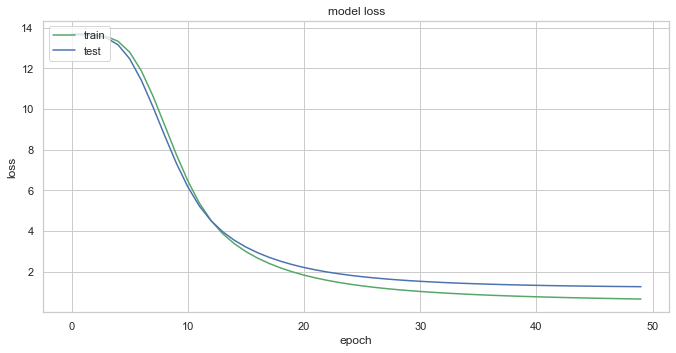

In [36]:
from pylab import rcParams
rcParams['figure.figsize'] = (10, 5)
import matplotlib.pyplot as plt
plt.plot(History.history['loss'], 'g')
plt.plot(History.history['val_loss'], 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

<a id="content5"></a>
## 5 ) Using a Neural Network

#### Now let us focus on the other main thing!!! Using a NN to matrix factorization.

1) Note that this way is not much different from the previous approach.

2) The main difference is that we have used Fully Connected layers as well as the Dropout layers and the BatchNormalization layers.

3) The number of units and the number of layers etc.. are the hyperparametrs here as in a traditional neural network.



### 5.1 ) Creating the Embeddings

####  Note that I have used 50 latent factors as that seems to give reasonable performance. Furhter tuning and careful optimization can give even better results.

In [37]:
n_latent_factors = 50
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

In [38]:
user_input = Input(shape=(1,), name='user_input', dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)
user_vec = Dropout(0.40)(user_vec)

In [39]:
movie_input = Input(shape=(1,), name='movie_input', dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = Dropout(0.40)(movie_vec)

In [40]:
sim = dot([user_vec, movie_vec], name='Similarity-Dot-Product', axes=1)

### 5.2. ) Specifying the Model architecture

In [41]:
nn_inp = Dense(96, activation='relu')(sim)
nn_inp = Dropout(0.4)(nn_inp)
# nn_inp=BatchNormalization()(nn_inp)
nn_inp = Dense(1, activation='relu')(nn_inp)
nn_model = keras.models.Model([user_input, movie_input], nn_inp)
nn_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        33550       user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        453300      movie_input[0][0]                
_______________________________________________________________________________________

#### Notice the summary of the model and also the architecture of the model which u can tune of course.

### 5.3 ) Compiling the Model

In [42]:
nn_model.compile(optimizer=Adam(lr=1e-3), loss='mse')

In [43]:
batch_size = 128
epochs = 20

### 5.4 ) Fitting on Training set & Validating on Validation Set.

In [44]:
History = nn_model.fit([train.userId, train.movieId],
                      train.rating,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=([valid.userId, valid.movieId], valid.rating),
                      verbose=1)

Epoch 1/20
627/627 [==============================] - 2s 3ms/step - loss: 2.9921 - val_loss: 1.1230
Epoch 2/20
627/627 [==============================] - 2s 3ms/step - loss: 1.1919 - val_loss: 0.9936
Epoch 3/20
627/627 [==============================] - 2s 3ms/step - loss: 0.9489 - val_loss: 0.9194
Epoch 4/20
627/627 [==============================] - 2s 3ms/step - loss: 0.8212 - val_loss: 0.8973
Epoch 5/20
627/627 [==============================] - 2s 3ms/step - loss: 0.7584 - val_loss: 0.8875
Epoch 6/20
627/627 [==============================] - 2s 3ms/step - loss: 0.7095 - val_loss: 0.8774
Epoch 7/20
627/627 [==============================] - 2s 3ms/step - loss: 0.6739 - val_loss: 0.8696
Epoch 8/20
627/627 [==============================] - 2s 3ms/step - loss: 0.6336 - val_loss: 0.8666
Epoch 9/20
627/627 [==============================] - 2s 3ms/step - loss: 0.6089 - val_loss: 0.8621
Epoch 10/20
627/627 [==============================] - 2s 3ms/step - loss: 0.5818 - val_loss: 0.8597

#### Note that the validation loss is close to 0.84 which is quite decent. Also note that it has decrreased from 1.26 in the case of normal Matrix Factorization to this value here.


####  Similary playing with no of latent factors,  other parameters in the model architecture can give to even better results